# Movie Recommendation System - Complete Walkthrough

This notebook demonstrates the complete pipeline of the movie recommendation system:
1. Data Loading and Exploration
2. Data Cleaning and Preprocessing
3. Feature Engineering
4. Model Training (4 models)
5. Model Evaluation
6. Generating Recommendations

In [3]:
# Setup
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import load_npz
import pickle
import warnings
warnings.filterwarnings('ignore')

from config import RAW_DATA_DIR, PROCESSED_DATA_DIR, FEATURES_DIR, SAVED_MODELS_DIR

print("Setup complete!")

Setup complete!


## 1. Data Loading and Exploration

In [4]:
# Load raw data
movies_raw = pd.read_csv(RAW_DATA_DIR / 'movies.csv')
ratings_raw = pd.read_csv(RAW_DATA_DIR / 'ratings.csv')

print(f"Movies: {len(movies_raw):,} rows")
print(f"Ratings: {len(ratings_raw):,} rows")
print(f"Unique Users: {ratings_raw['userId'].nunique():,}")
print(f"Unique Movies: {ratings_raw['movieId'].nunique():,}")

Movies: 62,423 rows
Ratings: 25,000,095 rows
Unique Users: 162,541
Unique Movies: 59,047


In [5]:
# Preview movies
movies_raw.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [6]:
# Preview ratings
ratings_raw.head(10)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
5,1,1088,4.0,1147868495
6,1,1175,3.5,1147868826
7,1,1217,3.5,1147878326
8,1,1237,5.0,1147868839
9,1,1250,4.0,1147868414


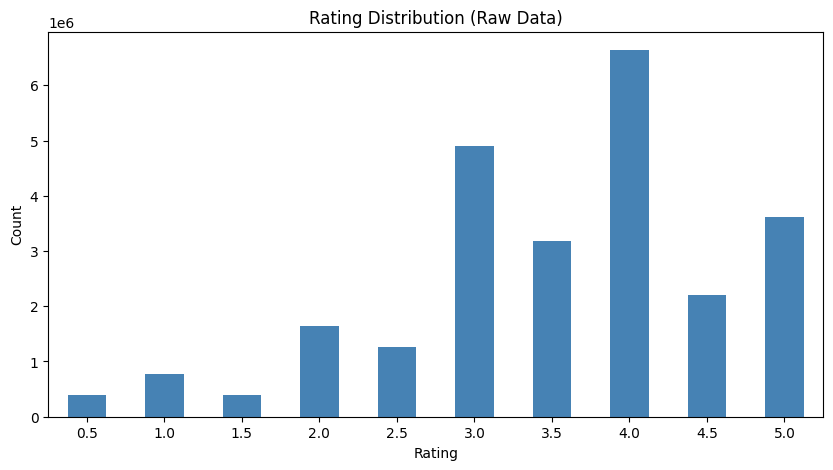

Mean Rating: 3.53
Median Rating: 3.50


In [7]:
# Rating distribution
plt.figure(figsize=(10, 5))
ratings_raw['rating'].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title('Rating Distribution (Raw Data)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

print(f"Mean Rating: {ratings_raw['rating'].mean():.2f}")
print(f"Median Rating: {ratings_raw['rating'].median():.2f}")

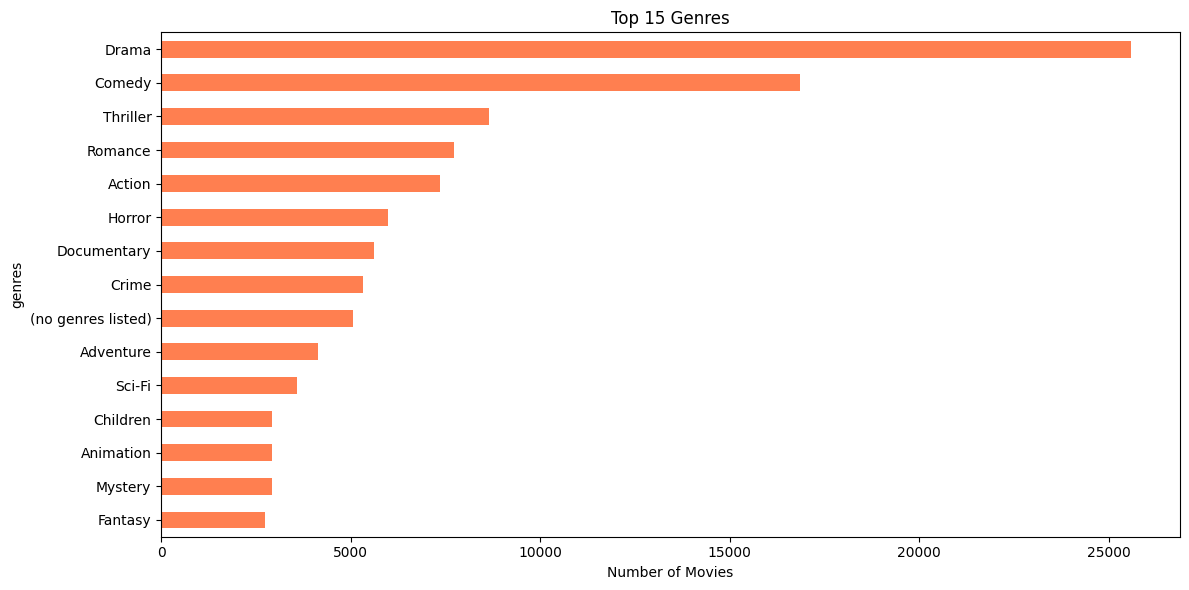

In [8]:
# Genre distribution
all_genres = movies_raw['genres'].str.split('|').explode()
genre_counts = all_genres.value_counts().head(15)

plt.figure(figsize=(12, 6))
genre_counts.plot(kind='barh', color='coral')
plt.title('Top 15 Genres')
plt.xlabel('Number of Movies')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 2. Data Cleaning

In [9]:
# Load cleaned data
movies_clean = pd.read_csv(PROCESSED_DATA_DIR / 'movies_cleaned.csv')
ratings_clean = pd.read_csv(PROCESSED_DATA_DIR / 'ratings_cleaned.csv')

print("After Cleaning:")
print(f"Movies: {len(movies_clean):,} rows")
print(f"Ratings: {len(ratings_clean):,} rows")
print(f"\nRemoved {len(movies_raw) - len(movies_clean):,} movies")
print(f"Removed {len(ratings_raw) - len(ratings_clean):,} ratings")

After Cleaning:
Movies: 62,423 rows
Ratings: 24,890,583 rows

Removed 0 movies
Removed 109,512 ratings


In [10]:
# Check for missing values
print("Missing Values in Movies:")
print(movies_clean.isnull().sum())
print("\nMissing Values in Ratings:")
print(ratings_clean.isnull().sum())

Missing Values in Movies:
movieId          0
title            0
genres           0
genres_list      0
year           412
dtype: int64

Missing Values in Ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


## 3. Feature Engineering

In [11]:
# Load interaction matrix
interaction_matrix = load_npz(FEATURES_DIR / 'interaction_matrix.npz')

print(f"Interaction Matrix Shape: {interaction_matrix.shape}")
print(f"Non-zero entries: {interaction_matrix.nnz:,}")
print(f"Sparsity: {(1 - interaction_matrix.nnz / (interaction_matrix.shape[0] * interaction_matrix.shape[1])) * 100:.2f}%")

Interaction Matrix Shape: (162541, 24330)
Non-zero entries: 19,848,470
Sparsity: 99.50%


In [12]:
# Load mappings
with open(FEATURES_DIR / 'mappings.pkl', 'rb') as f:
    mappings = pickle.load(f)

print(f"User ID Map: {len(mappings['user_id_map']):,} users")
print(f"Movie ID Map: {len(mappings['movie_id_map']):,} movies")
print(f"Mean Rating: {mappings['mean_rating']:.2f}")

User ID Map: 162,541 users
Movie ID Map: 24,330 movies
Mean Rating: 3.54


In [13]:
# Train/Test Split
train_ratings = pd.read_csv(FEATURES_DIR / 'train_ratings.csv')
test_ratings = pd.read_csv(FEATURES_DIR / 'test_ratings.csv')

print(f"Training set: {len(train_ratings):,} ratings")
print(f"Test set: {len(test_ratings):,} ratings")
print(f"Split ratio: {len(train_ratings)/(len(train_ratings)+len(test_ratings))*100:.1f}% / {len(test_ratings)/(len(train_ratings)+len(test_ratings))*100:.1f}%")

Training set: 19,848,470 ratings
Test set: 5,042,113 ratings
Split ratio: 79.7% / 20.3%


## 4. Model Training

In [14]:
# Load trained models
from models.user_based_cf import UserBasedCF
from models.item_based_cf import ItemBasedCF
from models.neural_cf import NeuralCF
from models.hybrid_model import HybridModel

user_based = UserBasedCF.load(SAVED_MODELS_DIR / 'user_based_cf.pkl')
item_based = ItemBasedCF.load(SAVED_MODELS_DIR / 'item_based_cf.pkl')
neural_cf = NeuralCF.load(SAVED_MODELS_DIR / 'neural_cf.pkl')
hybrid = HybridModel.load(
    SAVED_MODELS_DIR / 'hybrid_model.pkl',
    user_based, item_based, neural_cf
)

print("All models loaded successfully!")

Model loaded from d:\Project\Git\Movie_Recommendation_System\notebooks\..\models\saved\user_based_cf.pkl
Model loaded from d:\Project\Git\Movie_Recommendation_System\notebooks\..\models\saved\item_based_cf.pkl
Model loaded from d:\Project\Git\Movie_Recommendation_System\notebooks\..\models\saved\neural_cf.pkl
Hybrid model weights: {'user_based': 0.3, 'item_based': 0.3, 'neural_cf': 0.4}
Hybrid model loaded from d:\Project\Git\Movie_Recommendation_System\notebooks\..\models\saved\hybrid_model.pkl
All models loaded successfully!


In [15]:
# Model summary
print("User-Based CF:")
print(f"  - k_neighbors: {user_based.k_neighbors}")
print(f"  - Similarity matrix: {user_based.user_similarity.shape}")
print(f"  - Sampled users: {len(user_based.sampled_user_indices) if user_based.sampled_user_indices is not None else 'All'}")

print("\nItem-Based CF:")
print(f"  - k_neighbors: {item_based.k_neighbors}")
print(f"  - Similarity matrix: {item_based.item_similarity.shape}")

print("\nNeural CF:")
print(f"  - Hidden layers: {neural_cf.hidden_layers}")

print("\nHybrid Model:")
print(f"  - Weights: {hybrid.weights}")

User-Based CF:
  - k_neighbors: 50
  - Similarity matrix: (10000, 10000)
  - Sampled users: 10000

Item-Based CF:
  - k_neighbors: 50
  - Similarity matrix: (24330, 24330)

Neural CF:
  - Hidden layers: (64, 32, 16)

Hybrid Model:
  - Weights: {'user_based': 0.3, 'item_based': 0.3, 'neural_cf': 0.4}


## 5. Model Evaluation

In [16]:
# Load evaluation metrics
import json

with open(SAVED_MODELS_DIR / 'evaluation_metrics.json', 'r') as f:
    metrics = json.load(f)

metrics_df = pd.DataFrame(metrics)
metrics_df.columns = ['Model', 'RMSE', 'MAE', 'Precision@10', 'Recall@10']
metrics_df

,Model,RMSE,MAE,Precision@10,Recall@10
0,user_based,1.043852,0.823561,0.001010,0.000777
1,item_based,0.861886,0.638264,0.005155,0.006061
2,neural_cf,1.039497,0.821120,0.010000,0.006659
3,hybrid,0.940975,0.738226,0.014141,0.007388


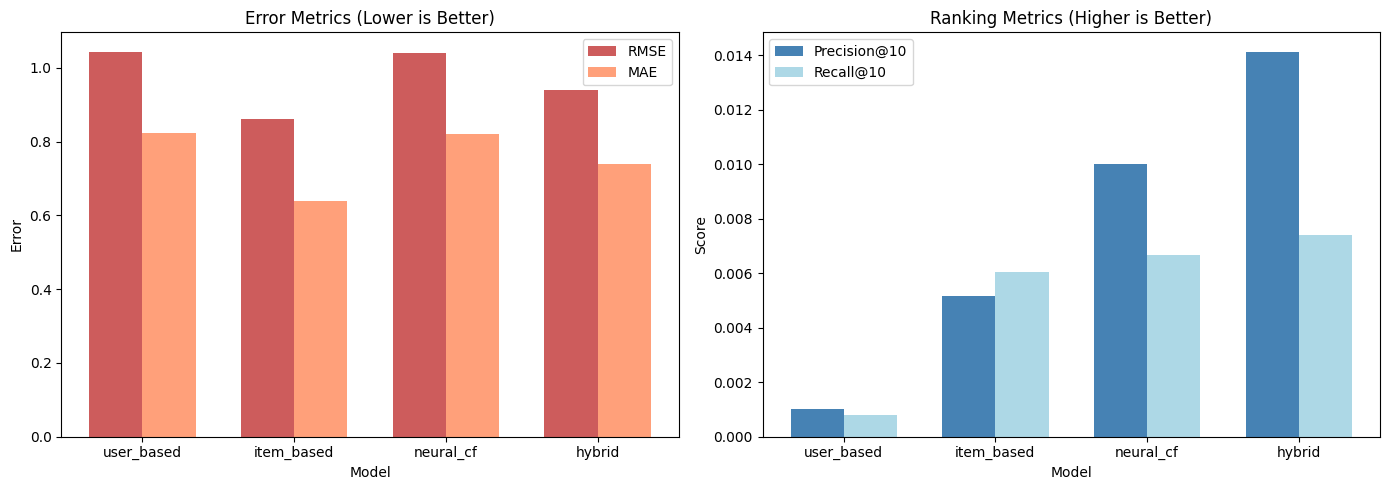

In [17]:
# Visualize metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error metrics
x = range(len(metrics_df))
width = 0.35
axes[0].bar([i - width/2 for i in x], metrics_df['RMSE'], width, label='RMSE', color='indianred')
axes[0].bar([i + width/2 for i in x], metrics_df['MAE'], width, label='MAE', color='lightsalmon')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Error')
axes[0].set_title('Error Metrics (Lower is Better)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_df['Model'])
axes[0].legend()

# Ranking metrics
axes[1].bar([i - width/2 for i in x], metrics_df['Precision@10'], width, label='Precision@10', color='steelblue')
axes[1].bar([i + width/2 for i in x], metrics_df['Recall@10'], width, label='Recall@10', color='lightblue')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Score')
axes[1].set_title('Ranking Metrics (Higher is Better)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_df['Model'])
axes[1].legend()

plt.tight_layout()
plt.show()

In [18]:
# Best models
print("Best Models:")
print(f"  Best RMSE: {metrics_df.loc[metrics_df['RMSE'].idxmin(), 'Model']} ({metrics_df['RMSE'].min():.4f})")
print(f"  Best MAE: {metrics_df.loc[metrics_df['MAE'].idxmin(), 'Model']} ({metrics_df['MAE'].min():.4f})")
print(f"  Best Precision@10: {metrics_df.loc[metrics_df['Precision@10'].idxmax(), 'Model']} ({metrics_df['Precision@10'].max():.4f})")
print(f"  Best Recall@10: {metrics_df.loc[metrics_df['Recall@10'].idxmax(), 'Model']} ({metrics_df['Recall@10'].max():.4f})")

Best Models:
  Best RMSE: item_based (0.8619)
  Best MAE: item_based (0.6383)
  Best Precision@10: hybrid (0.0141)
  Best Recall@10: hybrid (0.0074)


## 6. Generating Recommendations

In [19]:
# Select a test user
test_user_id = test_ratings['userId'].iloc[0]
print(f"Generating recommendations for User {test_user_id}")

# User's rated movies
user_ratings = ratings_clean[ratings_clean['userId'] == test_user_id].merge(
    movies_clean, on='movieId'
)[['title', 'genres', 'rating']].sort_values('rating', ascending=False)

print(f"\nUser's top rated movies:")
user_ratings.head(10)

Generating recommendations for User 1

User's top rated movies:


,title,genres,rating
0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,5.0
18,"Saragossa Manuscript, The (Rekopis znaleziony ...",Adventure|Drama|Mystery,5.0
57,Dolls (2002),Drama|Romance,5.0
56,"Dolce Vita, La (1960)",Drama,5.0
48,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,5.0
41,Lost in Translation (2003),Comedy|Drama|Romance,5.0
37,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,5.0
33,Teddy Bear (Mis) (1981),Comedy|Crime,5.0
26,"Night, The (Notte, La) (1960)",Drama,5.0
24,In the Mood For Love (Fa yeung nin wa) (2000),Drama|Romance,5.0


In [20]:
# Get recommendations from each model
models = {
    'User-Based CF': user_based,
    'Item-Based CF': item_based,
    'Neural CF': neural_cf,
    'Hybrid': hybrid
}

for model_name, model in models.items():
    print(f"\n{model_name} Recommendations:")
    recs = model.recommend(test_user_id, k=5)
    
    for i, (movie_id, score) in enumerate(recs, 1):
        movie = movies_clean[movies_clean['movieId'] == movie_id]
        if len(movie) > 0:
            title = movie.iloc[0]['title']
            genres = movie.iloc[0]['genres']
            print(f"  {i}. {title} ({genres}) - Score: {score:.2f}")


User-Based CF Recommendations:
  1. Planet Earth II (2016) (Documentary) - Score: 5.00
  2. Anna (1996) (Drama) - Score: 5.00
  3. Man and a Woman, A (Un homme et une femme) (1966) (Drama|Romance) - Score: 5.00
  4. Herod's Law (Ley de Herodes, La) (2000) (Comedy|Crime|Mystery) - Score: 5.00
  5. Careful (1992) (Comedy|Horror) - Score: 5.00

Item-Based CF Recommendations:
  1. Vanilla Sky (2001) (Mystery|Romance|Sci-Fi|Thriller) - Score: 5.00
  2. Her (2013) (Drama|Romance|Sci-Fi) - Score: 5.00
  3. Human Traffic (1999) (Comedy) - Score: 5.00
  4. Igby Goes Down (2002) (Comedy|Drama) - Score: 5.00
  5. Following (1998) (Crime|Mystery|Thriller) - Score: 5.00

Neural CF Recommendations:
  1. Psycho (1960) (Crime|Horror) - Score: 3.96
  2. Ran (1985) (Drama|War) - Score: 3.96
  3. 12 Angry Men (1957) (Drama) - Score: 3.94
  4. Once Upon a Time in America (1984) (Crime|Drama) - Score: 3.94
  5. Raging Bull (1980) (Drama) - Score: 3.94

Hybrid Recommendations:
  1. Clockwork Orange, A (197

In [21]:
# Similar movies (Item-Based CF)
sample_movie_id = movies_clean['movieId'].iloc[0]
sample_movie = movies_clean[movies_clean['movieId'] == sample_movie_id].iloc[0]

print(f"Finding movies similar to: {sample_movie['title']}")
print(f"Genres: {sample_movie['genres']}")

similar = item_based.get_similar_movies(sample_movie_id, k=5)
print("\nSimilar Movies:")
for i, (movie_id, score) in enumerate(similar, 1):
    movie = movies_clean[movies_clean['movieId'] == movie_id]
    if len(movie) > 0:
        title = movie.iloc[0]['title']
        genres = movie.iloc[0]['genres']
        print(f"  {i}. {title} ({genres}) - Similarity: {score:.3f}")

Finding movies similar to: Toy Story (1995)
Genres: Adventure|Animation|Children|Comedy|Fantasy

Similar Movies:
  1. Toy Story 2 (1999) (Adventure|Animation|Children|Comedy|Fantasy) - Similarity: 0.435
  2. Back to the Future (1985) (Adventure|Comedy|Sci-Fi) - Similarity: 0.423
  3. Star Wars: Episode IV - A New Hope (1977) (Action|Adventure|Sci-Fi) - Similarity: 0.418
  4. Star Wars: Episode VI - Return of the Jedi (1983) (Action|Adventure|Sci-Fi) - Similarity: 0.410
  5. Men in Black (a.k.a. MIB) (1997) (Action|Comedy|Sci-Fi) - Similarity: 0.399


## Summary

This notebook demonstrated:

1. **Data**: 25M+ ratings from 160K users on 60K movies
2. **Preprocessing**: Cleaning, TF-IDF vectorization, sparse matrix representation
3. **Models**: User-Based CF, Item-Based CF, Neural CF, Hybrid
4. **Metrics**: RMSE, MAE, Precision@K, Recall@K
5. **Best Performers**: Item-Based CF for accuracy, Hybrid for ranking